# Data Modelling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plot_utils import save_plot_to_png
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel
import string
import torch
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

In [2]:
# pip install xgboost

In [3]:
city = 'london'
df_original = pd.read_csv('./Data/london_data_processed.csv')

In [4]:
df = df_original.copy()

In [5]:
df.head()

,price,house_type,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,tenure,lease_time,service_charge,tax_band,...,latitude,longitude,school_1_distance,school_2_distance,train_1_distance,train_2_distance,has_garden,has_parking,old_new,word_count
0,300000.0,flat,1,1,1,650.0,leasehold,118.0,1541.2,C,...,51.401890,0.015865,0.2,0.2,0.2,0.5,0,0,Y,149
1,125000.0,studio,1,1,1,550.8,leasehold,82.0,816.0,B,...,51.459864,0.042868,0.1,0.1,0.4,1.0,0,0,Y,374
2,595000.0,terraced house,3,2,1,1202.2,freehold,0.0,3077.8,E,...,51.411739,0.036798,0.3,0.3,0.5,0.7,0,0,Y,115
3,1499950.0,detached house,5,1,1,613.0,freehold,0.0,1752.0,G,...,51.416840,0.025992,0.4,0.5,0.4,0.7,0,0,Y,233
4,595000.0,terraced house,3,1,3,1097.6,freehold,0.0,2479.8,D,...,51.543925,-0.028025,0.1,0.2,0.6,0.8,0,0,Y,533


In [6]:
description = df.describe().round(2).transpose()

In [7]:
description

,count,mean,std,min,25%,50%,75%,max
price,45870.0,769096.10,704677.03,100000.00,399950.00,569995.00,850000.00,8000000.00
number_of_bedrooms,45870.0,2.36,1.11,1.00,2.00,2.00,3.00,6.00
number_of_bathrooms,45870.0,1.48,0.66,1.00,1.00,1.00,2.00,4.00
number_of_receptions,45870.0,1.24,0.49,1.00,1.00,1.00,1.00,3.00
property_size,45870.0,935.34,486.21,127.00,574.20,774.80,1143.00,2846.20
lease_time,45870.0,232.06,315.67,0.00,0.00,102.40,285.35,1088.00
service_charge,45870.0,3213.18,2806.18,0.00,1558.20,2286.40,3670.90,18817.20
ground_rent,45870.0,157.43,208.28,0.00,0.00,81.00,248.00,1374.00
latitude,45870.0,51.50,0.11,43.54,51.46,51.50,51.54,57.58
longitude,45870.0,-0.14,0.14,-5.07,-0.21,-0.15,-0.08,3.98


In [8]:
description.to_excel('./Data/london_dataset_description.xlsx', engine='openpyxl')

In [9]:
# renaming target column
cols = list(df.columns)
cols[0] = 'price_target'
df.columns = cols
df.head()

,price_target,house_type,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,tenure,lease_time,service_charge,tax_band,...,latitude,longitude,school_1_distance,school_2_distance,train_1_distance,train_2_distance,has_garden,has_parking,old_new,word_count
0,300000.0,flat,1,1,1,650.0,leasehold,118.0,1541.2,C,...,51.401890,0.015865,0.2,0.2,0.2,0.5,0,0,Y,149
1,125000.0,studio,1,1,1,550.8,leasehold,82.0,816.0,B,...,51.459864,0.042868,0.1,0.1,0.4,1.0,0,0,Y,374
2,595000.0,terraced house,3,2,1,1202.2,freehold,0.0,3077.8,E,...,51.411739,0.036798,0.3,0.3,0.5,0.7,0,0,Y,115
3,1499950.0,detached house,5,1,1,613.0,freehold,0.0,1752.0,G,...,51.416840,0.025992,0.4,0.5,0.4,0.7,0,0,Y,233
4,595000.0,terraced house,3,1,3,1097.6,freehold,0.0,2479.8,D,...,51.543925,-0.028025,0.1,0.2,0.6,0.8,0,0,Y,533


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45870 entries, 0 to 45869
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price_target          45870 non-null  float64
 1   house_type            45870 non-null  object 
 2   number_of_bedrooms    45870 non-null  int64  
 3   number_of_bathrooms   45870 non-null  int64  
 4   number_of_receptions  45870 non-null  int64  
 5   property_size         45870 non-null  float64
 6   tenure                45870 non-null  object 
 7   lease_time            45870 non-null  float64
 8   service_charge        45870 non-null  float64
 9   tax_band              45870 non-null  object 
 10  ground_rent           45870 non-null  float64
 11  description_text      45870 non-null  object 
 12  postcode              45870 non-null  object 
 13  latitude              45870 non-null  float64
 14  longitude             45870 non-null  float64
 15  school_1_distance  

In [11]:
df.drop(columns=['word_count'], inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45870 entries, 0 to 45869
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price_target          45870 non-null  float64
 1   house_type            45870 non-null  object 
 2   number_of_bedrooms    45870 non-null  int64  
 3   number_of_bathrooms   45870 non-null  int64  
 4   number_of_receptions  45870 non-null  int64  
 5   property_size         45870 non-null  float64
 6   tenure                45870 non-null  object 
 7   lease_time            45870 non-null  float64
 8   service_charge        45870 non-null  float64
 9   tax_band              45870 non-null  object 
 10  ground_rent           45870 non-null  float64
 11  description_text      45870 non-null  object 
 12  postcode              45870 non-null  object 
 13  latitude              45870 non-null  float64
 14  longitude             45870 non-null  float64
 15  school_1_distance  

## Normalization of numerical data

In [13]:
scaler = MinMaxScaler()

In [14]:
numerical_columns = ['price_target', 'number_of_bedrooms', 'number_of_bathrooms', 'number_of_receptions', 'property_size', 'lease_time', 
                  'service_charge','ground_rent', 'latitude', 'longitude', 'school_1_distance', 'school_2_distance', 
                  'train_1_distance', 'train_2_distance']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [15]:
df.head()

,price_target,house_type,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,tenure,lease_time,service_charge,tax_band,...,postcode,latitude,longitude,school_1_distance,school_2_distance,train_1_distance,train_2_distance,has_garden,has_parking,old_new
0,0.025316,flat,0.0,0.000000,0.0,0.192336,leasehold,0.108456,0.081904,C,...,BR1,0.559883,0.561802,0.333333,0.285714,0.133333,0.277778,0,0,Y
1,0.003165,studio,0.0,0.000000,0.0,0.155855,leasehold,0.075368,0.043365,B,...,BR1,0.564013,0.564784,0.166667,0.142857,0.266667,0.555556,0,0,Y
2,0.062658,terraced house,0.4,0.333333,0.0,0.395410,freehold,0.000000,0.163563,E,...,BR1,0.560585,0.564113,0.500000,0.428571,0.333333,0.388889,0,0,Y
3,0.177209,detached house,0.8,0.000000,0.0,0.178729,freehold,0.000000,0.093106,G,...,BR1,0.560948,0.562920,0.666667,0.714286,0.266667,0.388889,0,0,Y
4,0.062658,terraced house,0.4,0.000000,1.0,0.356943,freehold,0.000000,0.131784,D,...,BR1,0.570002,0.556956,0.166667,0.285714,0.400000,0.444444,0,0,Y


## Encode Categorical Columns

In [16]:
categorical_cols = ['tenure', 'tax_band', 'postcode', 'house_type', 'old_new']
encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' to avoid multicollinearity
encoded_category = encoder.fit_transform(df[categorical_cols])
df_encoded_category = pd.DataFrame(encoded_category, columns=encoder.get_feature_names_out(categorical_cols))

In [17]:
# Drop the original category column and concatenate the encoded one
df = df.drop(columns=categorical_cols, axis=1)
df = pd.concat([df, df_encoded_category], axis=1)

In [18]:
df.head()

,price_target,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,lease_time,service_charge,ground_rent,description_text,latitude,...,house_type_room,house_type_semi-detached bungalow,house_type_semi-detached house,house_type_shared accommodation,house_type_studio,house_type_terraced bungalow,house_type_terraced house,house_type_town house,house_type_unknown,old_new_Y
0,0.025316,0.0,0.000000,0.0,0.192336,0.108456,0.081904,0.465793,"guide price £300,000 - £325,000 \n\nthis love...",0.559883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.003165,0.0,0.000000,0.0,0.155855,0.075368,0.043365,0.181951,perfect residential or investment property wit...,0.564013,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.062658,0.4,0.333333,0.0,0.395410,0.000000,0.163563,0.000000,an immaculately presented three bedroom mid te...,0.560585,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.177209,0.8,0.000000,0.0,0.178729,0.000000,0.093106,0.000000,an exceptional five bedroom detached cottage s...,0.560948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.062658,0.4,0.000000,1.0,0.356943,0.000000,0.131784,0.000000,a charming 1930s mid-terrace house offering a ...,0.570002,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45870 entries, 0 to 45869
Columns: 290 entries, price_target to old_new_Y
dtypes: float64(287), int64(2), object(1)
memory usage: 101.5+ MB


## Natural Language Processing

In [20]:
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK tag to first character used by WordNetLemmatizer
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [21]:
df['lemmatized_description'] = df['description_text'].apply(lambda x: lemmatize_sentence(x))

In [22]:
df['lemmatized_description'] 

0        guide price £300,000 - £325,000 this lovely ho...
1        perfect residential or investment property wit...
2        an immaculately present three bedroom mid terr...
3        an exceptional five bedroom detach cottage ste...
4        a charming 1930s mid-terrace house offer a com...
                               ...                        
45865    this attractive semi detach house require mode...
45866    a spacious brand new , three bedroom apartment...
45867    a brand new two bedroom balcony apartment situ...
45868    a contemporary one bedroom apartment within a ...
45869    if you be look for a spacious home which be ne...
Name: lemmatized_description, Length: 45870, dtype: object

### Bag of Words

In [23]:
vectorizer = CountVectorizer(max_features=1500, stop_words='english')
X = vectorizer.fit_transform(df['lemmatized_description'])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [24]:
bow_df.head()

,00,000,01,10,100,11,12,125,13,14,...,woolwich,work,worktop,worktops,world,wrap,yard,year,young,zone
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [25]:
bow_data = pd.concat([df, bow_df], axis=1)

In [26]:
bow_data.drop(columns=['description_text','lemmatized_description'], inplace=True)

In [27]:
bow_data.head()

,price_target,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,lease_time,service_charge,ground_rent,latitude,longitude,...,woolwich,work,worktop,worktops,world,wrap,yard,year,young,zone
0,0.025316,0.0,0.000000,0.0,0.192336,0.108456,0.081904,0.465793,0.559883,0.561802,...,0,0,0,0,0,0,0,0,0,0
1,0.003165,0.0,0.000000,0.0,0.155855,0.075368,0.043365,0.181951,0.564013,0.564784,...,0,0,0,0,0,0,0,3,0,2
2,0.062658,0.4,0.333333,0.0,0.395410,0.000000,0.163563,0.000000,0.560585,0.564113,...,0,0,0,0,0,0,0,0,0,0
3,0.177209,0.8,0.000000,0.0,0.178729,0.000000,0.093106,0.000000,0.560948,0.562920,...,0,0,0,0,0,0,0,0,0,0
4,0.062658,0.4,0.000000,1.0,0.356943,0.000000,0.131784,0.000000,0.570002,0.556956,...,0,1,0,0,0,0,0,0,0,0


In [28]:
bow_data.to_csv('./Data/london_bow_data.csv')

### Doc2Vec

In [29]:
# Tokenize the documents
tokenized_data = [text.split() for text in df['description_text']]

# Tag the data
tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(tokenized_data)]

# Train a Doc2Vec model
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Extract vectors for each document
vectors = [model.dv[str(i)] for i in range(len(tokenized_data))]

# Convert vectors to a DataFrame
doc2vec_df = pd.DataFrame(vectors)

In [30]:
doc2vec_df.shape

(45870, 20)

In [31]:
doc2vec_data = pd.concat([df, doc2vec_df], axis=1)

In [32]:
doc2vec_data.drop(columns=['description_text','lemmatized_description'], inplace=True)

In [33]:
doc2vec_data.head()

,price_target,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,lease_time,service_charge,ground_rent,latitude,longitude,...,10,11,12,13,14,15,16,17,18,19
0,0.025316,0.0,0.000000,0.0,0.192336,0.108456,0.081904,0.465793,0.559883,0.561802,...,0.495757,-0.876065,-2.362664,1.247455,-0.047027,-1.254113,0.709633,-0.456274,-0.096684,-2.376696
1,0.003165,0.0,0.000000,0.0,0.155855,0.075368,0.043365,0.181951,0.564013,0.564784,...,0.432830,-1.200188,-0.334454,1.353364,-0.510769,0.144963,-0.352539,-1.568868,0.129143,-1.961097
2,0.062658,0.4,0.333333,0.0,0.395410,0.000000,0.163563,0.000000,0.560585,0.564113,...,0.697253,0.941340,-1.977891,-0.751063,0.709927,2.237603,0.497965,-0.288966,0.868631,-2.912803
3,0.177209,0.8,0.000000,0.0,0.178729,0.000000,0.093106,0.000000,0.560948,0.562920,...,-0.214823,0.937578,-1.747523,-0.548444,1.597890,1.396799,0.275907,-1.090161,1.164753,-1.824652
4,0.062658,0.4,0.000000,1.0,0.356943,0.000000,0.131784,0.000000,0.570002,0.556956,...,0.914369,-0.544974,-2.337029,1.310332,1.025423,-0.628162,1.258426,-0.525487,-0.629269,-2.427305


In [34]:
doc2vec_data.to_csv('./Data/london_doc2vec_data.csv')

### Bert 

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts, batch_size=10):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=256) # Reduced max_length
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

# Get embeddings for the 'text' column
embeddings = get_bert_embeddings(df['description_text'].tolist())

# Convert embeddings to a dataframe
embeddings_df = pd.DataFrame(embeddings)

In [36]:
embeddings_df.shape

(45870, 768)

In [37]:
bert_data = pd.concat([df, embeddings_df], axis=1)

In [38]:
bert_data.drop(columns=['description_text','lemmatized_description'], inplace=True)

In [39]:
bert_data.head()

,price_target,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,lease_time,service_charge,ground_rent,latitude,longitude,...,758,759,760,761,762,763,764,765,766,767
0,0.025316,0.0,0.000000,0.0,0.192336,0.108456,0.081904,0.465793,0.559883,0.561802,...,-0.093537,-0.166437,-0.030067,-0.097318,-0.211479,-0.413105,-0.041302,0.015865,-0.142445,-0.021780
1,0.003165,0.0,0.000000,0.0,0.155855,0.075368,0.043365,0.181951,0.564013,0.564784,...,-0.146151,-0.138207,0.070831,-0.156522,-0.113325,-0.354143,-0.201651,-0.132113,-0.016424,-0.082114
2,0.062658,0.4,0.333333,0.0,0.395410,0.000000,0.163563,0.000000,0.560585,0.564113,...,0.265395,0.052141,0.076688,-0.194989,-0.074858,-0.757908,-0.176259,-0.002247,-0.170257,0.036064
3,0.177209,0.8,0.000000,0.0,0.178729,0.000000,0.093106,0.000000,0.560948,0.562920,...,0.052966,0.030315,-0.034358,-0.310961,-0.032969,-0.815577,-0.139135,0.110077,-0.223808,-0.038954
4,0.062658,0.4,0.000000,1.0,0.356943,0.000000,0.131784,0.000000,0.570002,0.556956,...,-0.122144,-0.266703,-0.042607,-0.061524,-0.329421,-0.504934,0.137328,-0.009603,-0.123054,-0.011788


In [40]:
bert_data.to_csv('./Data/london_bert_data.csv')

## Regression Models

In [46]:
df_model = df.copy()
df_model.drop(columns=['description_text','lemmatized_description'], inplace=True)

In [47]:
df_model.to_csv('./Data/london_model_data.csv')

In [48]:
df_model.head()

,price_target,number_of_bedrooms,number_of_bathrooms,number_of_receptions,property_size,lease_time,service_charge,ground_rent,latitude,longitude,...,house_type_room,house_type_semi-detached bungalow,house_type_semi-detached house,house_type_shared accommodation,house_type_studio,house_type_terraced bungalow,house_type_terraced house,house_type_town house,house_type_unknown,old_new_Y
0,0.025316,0.0,0.000000,0.0,0.192336,0.108456,0.081904,0.465793,0.559883,0.561802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.003165,0.0,0.000000,0.0,0.155855,0.075368,0.043365,0.181951,0.564013,0.564784,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.062658,0.4,0.333333,0.0,0.395410,0.000000,0.163563,0.000000,0.560585,0.564113,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.177209,0.8,0.000000,0.0,0.178729,0.000000,0.093106,0.000000,0.560948,0.562920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.062658,0.4,0.000000,1.0,0.356943,0.000000,0.131784,0.000000,0.570002,0.556956,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [49]:
def mean_absolute_percentage_error(actual, forecast):
    """
    Calculate MAPE given a list of actual and forecasted values.
    
    :param actual: List of actual values
    :param forecast: List of forecasted values
    :return: MAPE as a float
    """
    if len(actual) != len(forecast):
        raise ValueError("Input lists must have the same length")
    
    # Avoid division by zero and calculate absolute percentage error for each point
    mape_list = [abs((a - f) / a) for a, f in zip(actual, forecast) if a != 0]
    
    # Compute mean of the absolute percentage errors
    mape = (100 * sum(mape_list)) / len(mape_list)
    
    return mape

### Ridge Regression (Base model)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'alpha': 0.18420699693267145}
Mean Squared Error: 135983951173.81833
RMSE: 368760.0184046778
MAE: 216158.0599704724
Mean Absolute Percentage Error: [31.95698741]
R^2: 0.7219312185641764


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


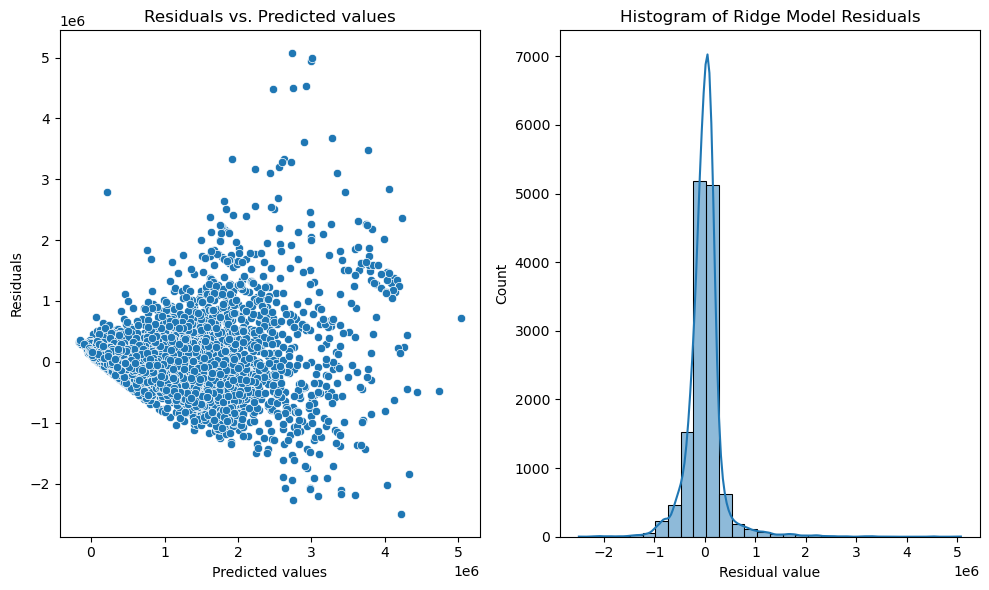

In [50]:
# splitting dependent variable and independent variables
X = df_model.drop(columns=['price_target'])
y = df_model['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
ridge = Ridge()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Rescaling y pred to original scale
# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Ridge Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Ridge - BOW Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'alpha': 0.5689866029018293}
Mean Squared Error: 117938631911.07103
RMSE: 343421.94442270434
MAE: 210271.44920044602
Mean Absolute Percentage Error: [32.20208741]
R^2: 0.7588314549133806


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


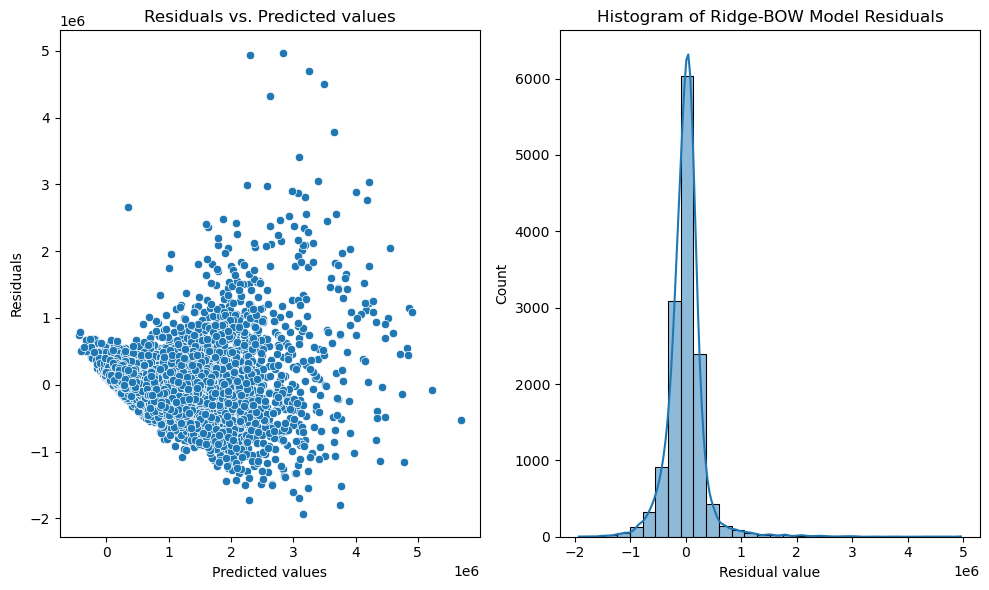

In [51]:
# splitting dependent variable and independent variables
X = bow_data.drop(columns=['price_target'])
y = bow_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
ridge_bow = Ridge()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=ridge_bow, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Rescaling y pred to original scale
# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Ridge-BOW Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Ridge - Doc2Vec Model 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best Parameters: {'alpha': 0.2682695795279725}
Mean Squared Error: 132851731578.0283
RMSE: 364488.31473454443
MAE: 215325.84530093856
Mean Absolute Percentage Error: [32.52241988]
R^2: 0.7283361838462739


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


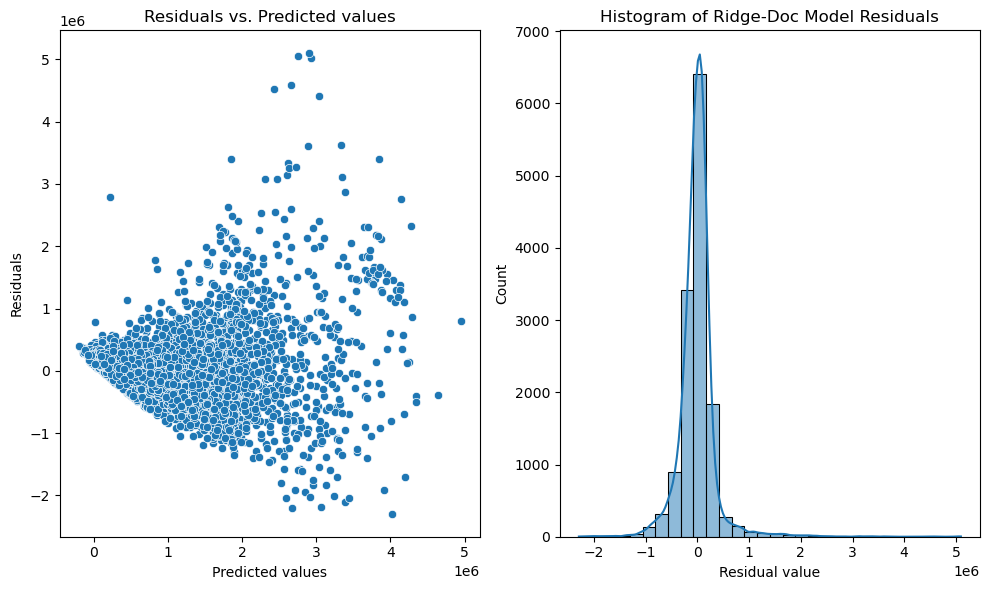

In [52]:
# splitting dependent variable and independent variables
X = doc2vec_data.drop(columns=['price_target'])
y = doc2vec_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
ridge_doc = Ridge()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=ridge_doc, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Ridge-Doc Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Ridge - Bert Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best Parameters: {'alpha': 2.559547922699533}
Mean Squared Error: 124955804210.5364
RMSE: 353490.88278276206
MAE: 213465.05885797978


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Mean Absolute Percentage Error: [32.57529754]
R^2: 0.7444822869888259


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


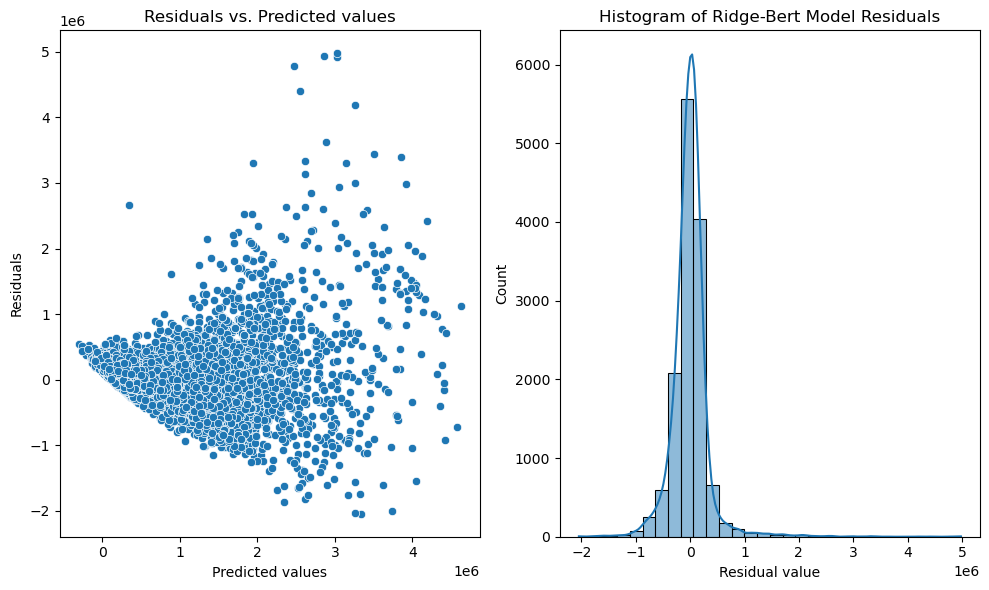

In [53]:
# splitting dependent variable and independent variables
X = bert_data.drop(columns=['price_target'])
y = bert_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
ridge_bert = Ridge()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=ridge_bert, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Ridge-Bert Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Lasso (Base Model)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'alpha': 0.0001}
Mean Squared Error: 152000467170.44193
RMSE: 389872.3729253484
MAE: 224881.7961973183
Mean Absolute Percentage Error: [32.85842331]
R^2: 0.6891796103958296


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


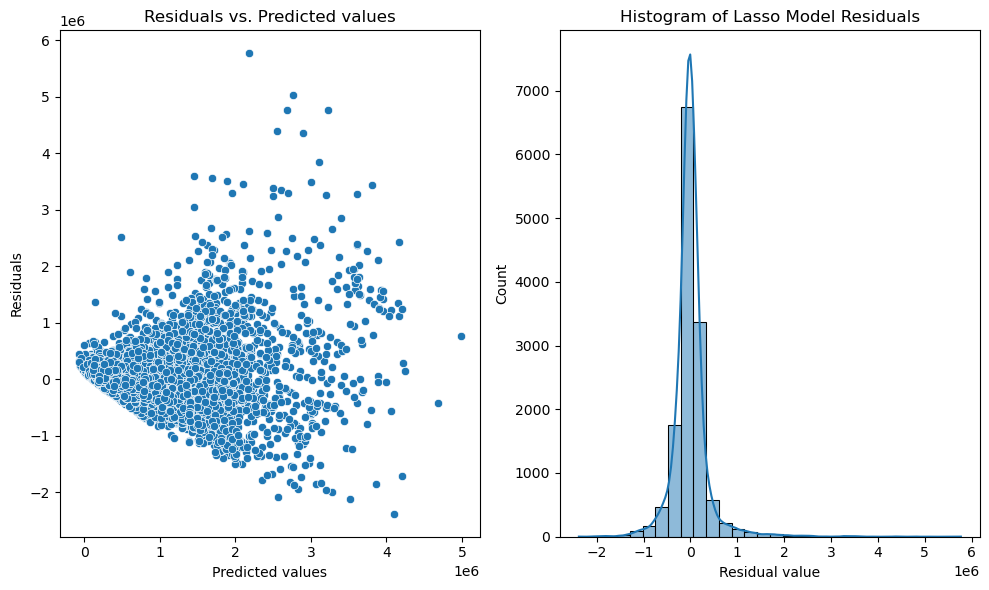

In [54]:
# splitting dependent variable and independent variables
X = df_model.drop(columns=['price_target'])
y = df_model['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
lasso = Lasso()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Lasso Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Lasso-Bow Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'alpha': 0.0001}
Mean Squared Error: 130377774780.99597
RMSE: 361078.6268681601
MAE: 210309.0272166084
Mean Absolute Percentage Error: [30.68700476]
R^2: 0.7333950907682849


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


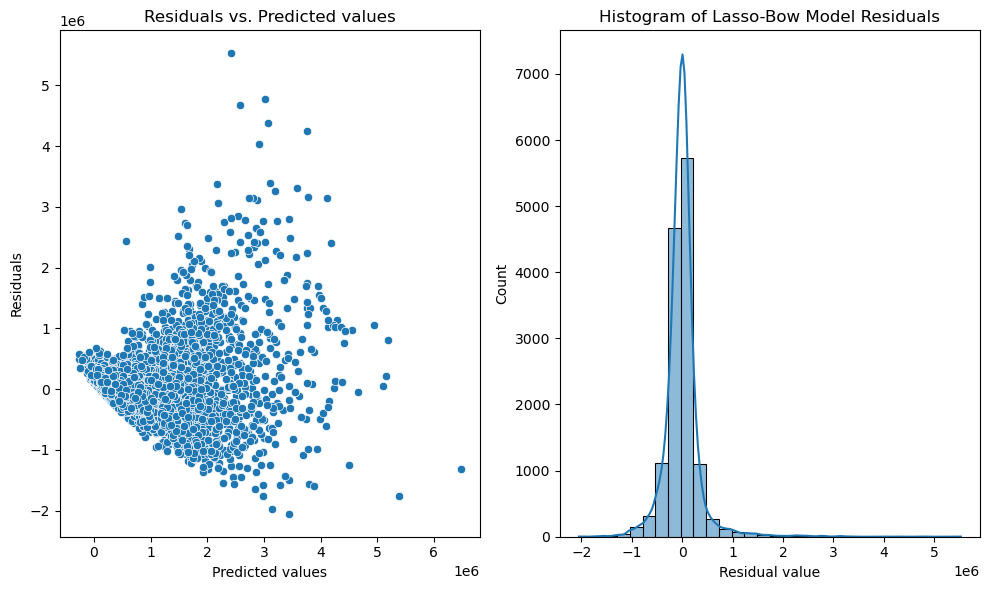

In [55]:
# splitting dependent variable and independent variables
X = bow_data.drop(columns=['price_target'])
y = bow_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
lasso_bow = Lasso()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lasso_bow, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Lasso-Bow Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show() 

### Lasso-Doc Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best Parameters: {'alpha': 0.0001}
Mean Squared Error: 146737553169.63806
RMSE: 383063.38009478024
MAE: 223914.701698583
Mean Absolute Percentage Error: [33.27165583]
R^2: 0.6999415574518791


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


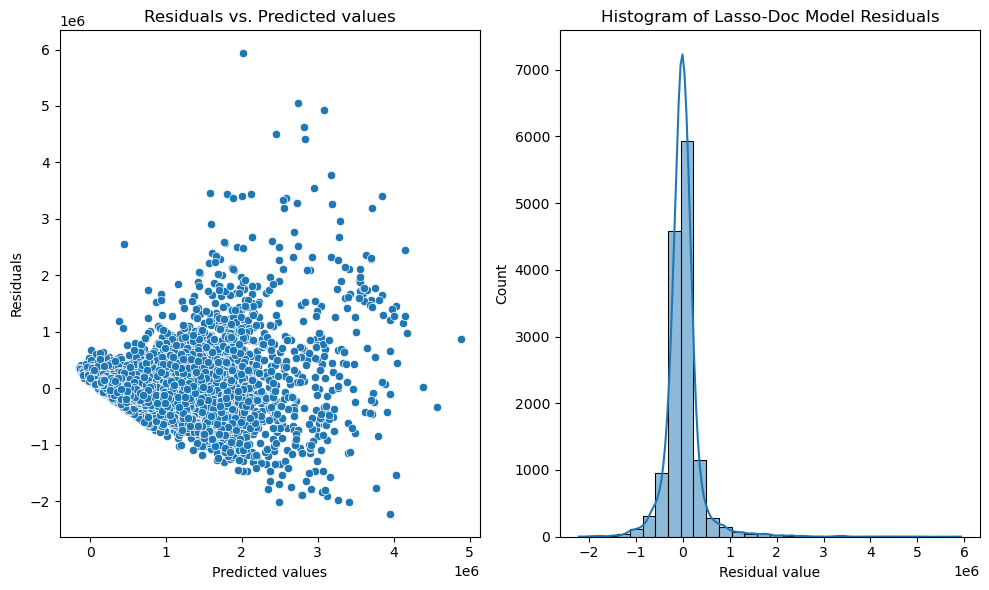

In [56]:
# splitting dependent variable and independent variables
X = doc2vec_data.drop(columns=['price_target'])
y = doc2vec_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
lasso_doc = Lasso()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lasso_doc, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Lasso-Doc Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show() 

### Lasso-Bert Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best Parameters: {'alpha': 0.0001}
Mean Squared Error: 142362853763.0502
RMSE: 377310.02340654854
MAE: 218615.4706916048
Mean Absolute Percentage Error: [32.02454456]
R^2: 0.7088872258387536


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


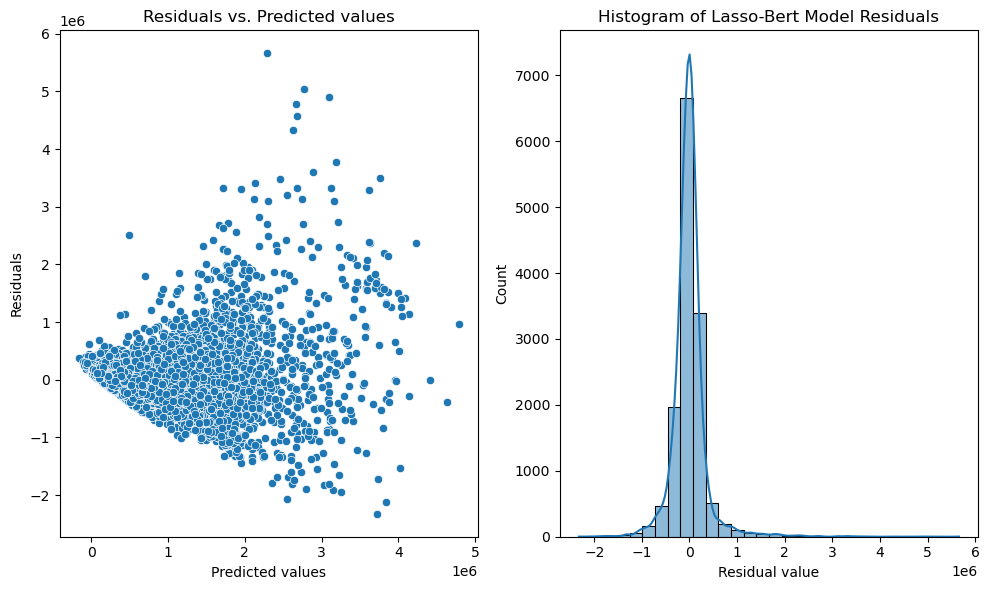

In [57]:
# splitting dependent variable and independent variables
X = bert_data.drop(columns=['price_target'])
y = bert_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


alphas = np.logspace(-4, 4, 50)  # Creating a range of potential alpha values
param_grid = {'alpha': alphas}

# Create Ridge regressor object
lasso_bert = Lasso()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lasso_bert, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Lasso-Bert Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Random Forest

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': True}
Mean Squared Error: 83938847966.15262
RMSE: 289722.0184351763
MAE: 145631.36657026492
Mean Absolute Percentage Error: [18.79284965]
R^2: 0.8283564128884583


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


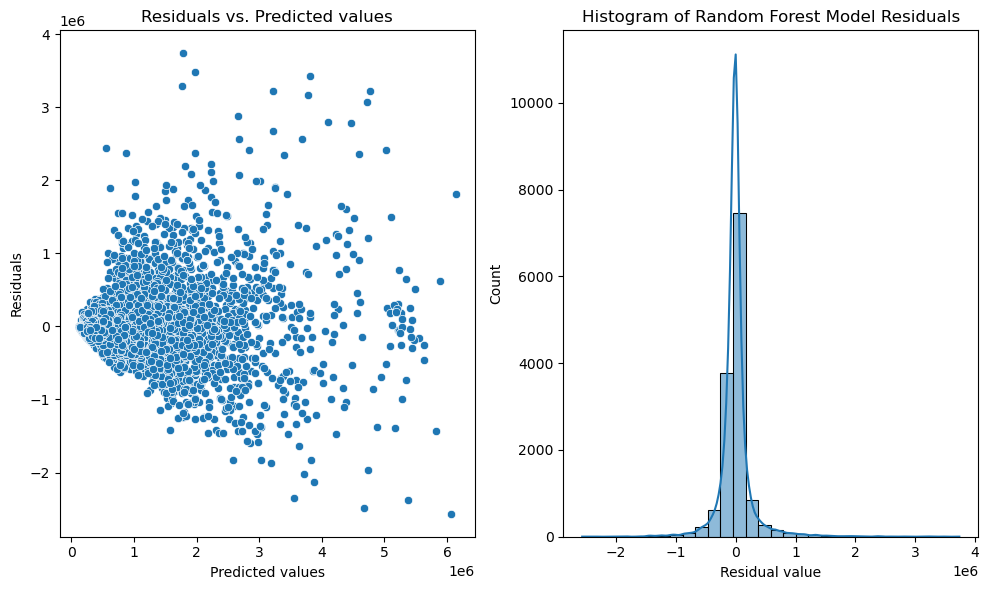

In [58]:
# splitting dependent variable and independent variables
X = df_model.drop(columns=['price_target'])
y = df_model['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Random Forest regressor
rf = RandomForestRegressor()

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)
# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Random Forest Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Random Forest-BOW model

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': True}
Mean Squared Error: 87089198302.9298
RMSE: 295108.7906229325
MAE: 150732.427516672
Mean Absolute Percentage Error: [19.29296447]
R^2: 0.8219143726941428


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


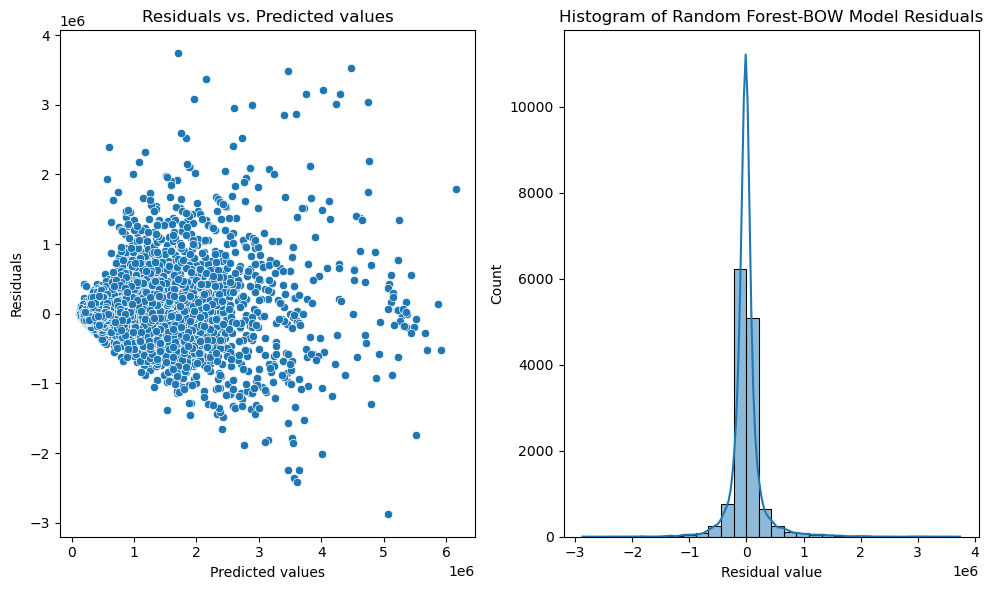

In [59]:
# splitting dependent variable and independent variables
X = bow_data.drop(columns=['price_target'])
y = bow_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Random Forest regressor
rf = RandomForestRegressor()

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)
# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Random Forest-BOW Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Random Forest-Doc Model

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': True}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Mean Squared Error: 97019616791.72752
RMSE: 311479.7213170185
MAE: 159630.49474371472
Mean Absolute Percentage Error: [20.8971964]
R^2: 0.8016080104764562


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


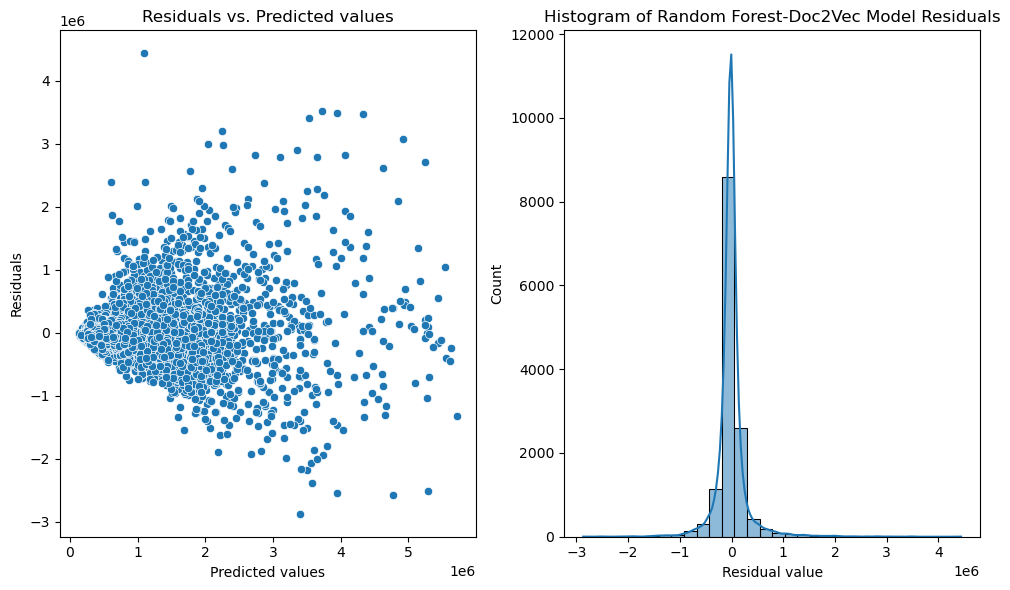

In [60]:
# splitting dependent variable and independent variables
X = doc2vec_data.drop(columns=['price_target'])
y = doc2vec_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Random Forest regressor
rf = RandomForestRegressor()

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)
# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Random Forest-Doc2Vec Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### Random Forest-Bert Model

In [61]:
# splitting dependent variable and independent variables
X = bert_data.drop(columns=['price_target'])
y = bert_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Random Forest regressor
rf = RandomForestRegressor()

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)
# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': True}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Mean Squared Error: 105115642965.13916
RMSE: 324215.42678462906
MAE: 170822.1969924468
Mean Absolute Percentage Error: [22.74373535]
R^2: 0.7850527323492933


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


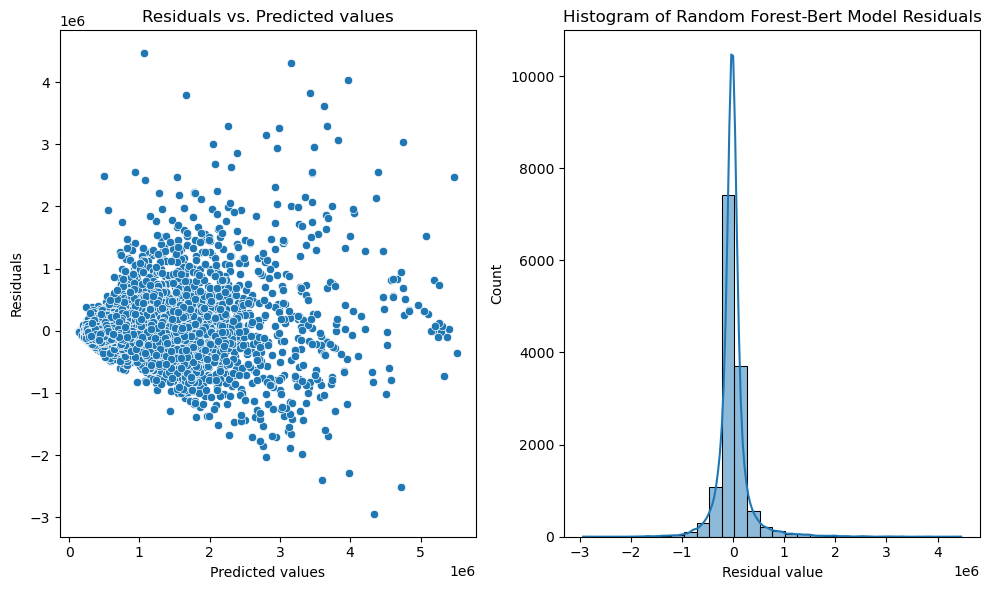

In [62]:
# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Random Forest-Bert Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### LightGBM

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2248
[LightGBM] [Info] Number of data points in the train set: 32109, number of used features: 262
[LightGBM] [Info] Start training from score 0.084629
Best Parameters: {'seed': 42, 'objective': 'regression', 'num_leaves': 15, 'n_estimators': 40, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}
Mean Squared Error: 98531690107.48798
RMSE: 313897.5790086441
MAE: 180921.71815509876
Mean Absolute Percentage Error: [26.81095104]
R^2: 0.7985160251302025


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


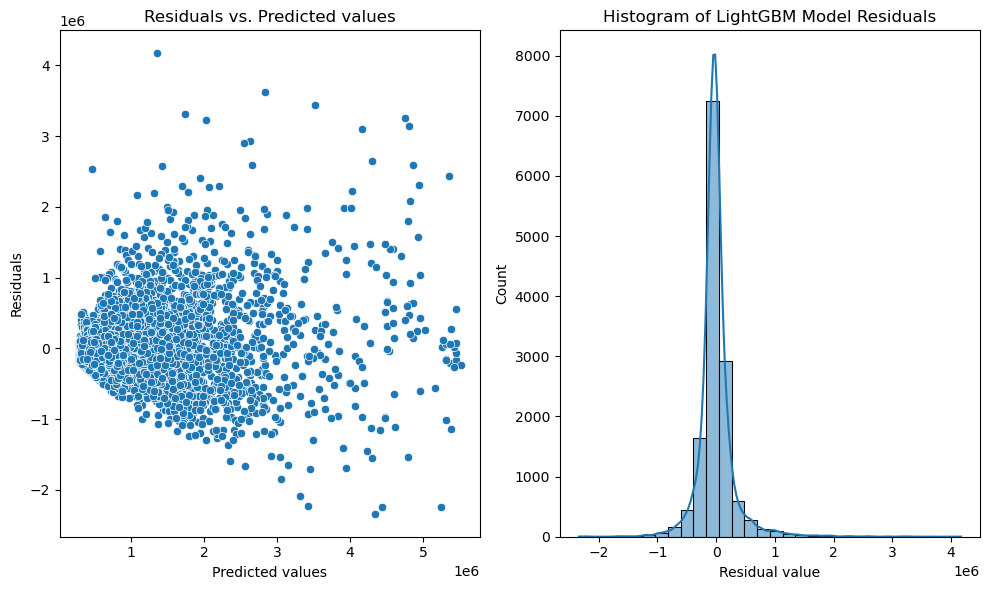

In [63]:
# splitting dependent variable and independent variables
X = df_model.drop(columns=['price_target'])
y = df_model['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define LightGBM regressor
model = lgb.LGBMRegressor()

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 60],
    'num_leaves': [15, 31, 63, 127],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'seed': [42]
}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of LightGBM Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### LightGBM-BOW Model

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11254
[LightGBM] [Info] Number of data points in the train set: 32109, number of used features: 1762
[LightGBM] [Info] Start training from score 0.084629
Best Parameters: {'seed': 42, 'objective': 'regression', 'num_leaves': 15, 'n_estimators': 40, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}
Mean Squared Error: 98963474846.54054
RMSE: 314584.60681753093
MAE: 180721.40861420328
Mean Absolute Percentage Error: [26.51280062]
R^2: 0.7976330837595884


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


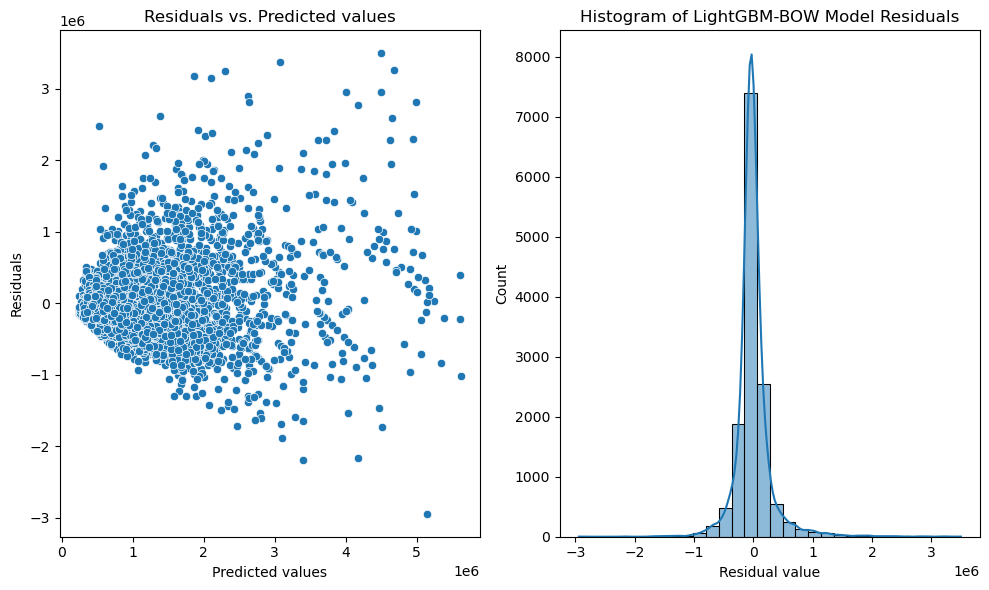

In [64]:
# splitting dependent variable and independent variables
X = bow_data.drop(columns=['price_target'])
y = bow_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define LightGBM regressor
model = lgb.LGBMRegressor()

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 60],
    'num_leaves': [15, 31, 63, 127],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'seed': [42]
}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of LightGBM-BOW Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### LightGBM-Doc Model

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7348
[LightGBM] [Info] Number of data points in the train set: 32109, number of used features: 282
[LightGBM] [Info] Start training from score 0.084629
Best Parameters: {'seed': 42, 'objective': 'regression', 'num_leaves': 15, 'n_estimators': 40, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}
Mean Squared Error: 101003393436.99506
RMSE: 317810.3104636397
MAE: 181518.59767522544
Mean Absolute Percentage Error: [26.81124499]
R^2: 0.7934617262443849


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


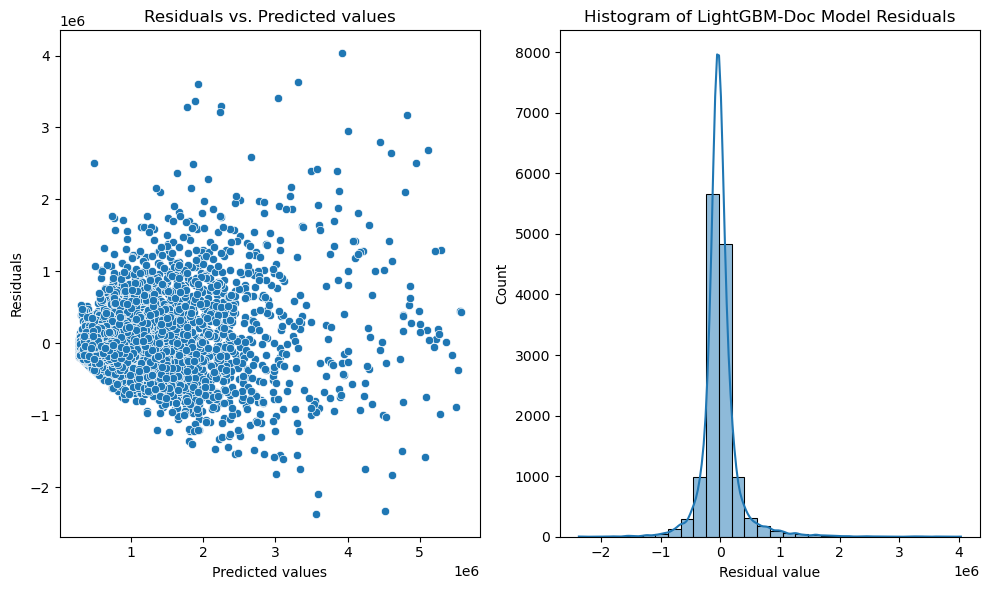

In [65]:
# splitting dependent variable and independent variables
X = doc2vec_data.drop(columns=['price_target'])
y = doc2vec_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define LightGBM regressor
model = lgb.LGBMRegressor()

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 60],
    'num_leaves': [15, 31, 63, 127],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'seed': [42]
}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of LightGBM-Doc Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()

### LightGBM-Bert Model

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.338614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198088
[LightGBM] [Info] Number of data points in the train set: 32109, number of used features: 1030
[LightGBM] [Info] Start training from score 0.084629
Best Parameters: {'seed': 42, 'objective': 'regression', 'num_leaves': 15, 'n_estimators': 40, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}
Mean Squared Error: 102956415205.22604
RMSE: 320868.2209338065
MAE: 182314.64424459112
Mean Absolute Percentage Error: [26.82448955]
R^2: 0.7894680609734336


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


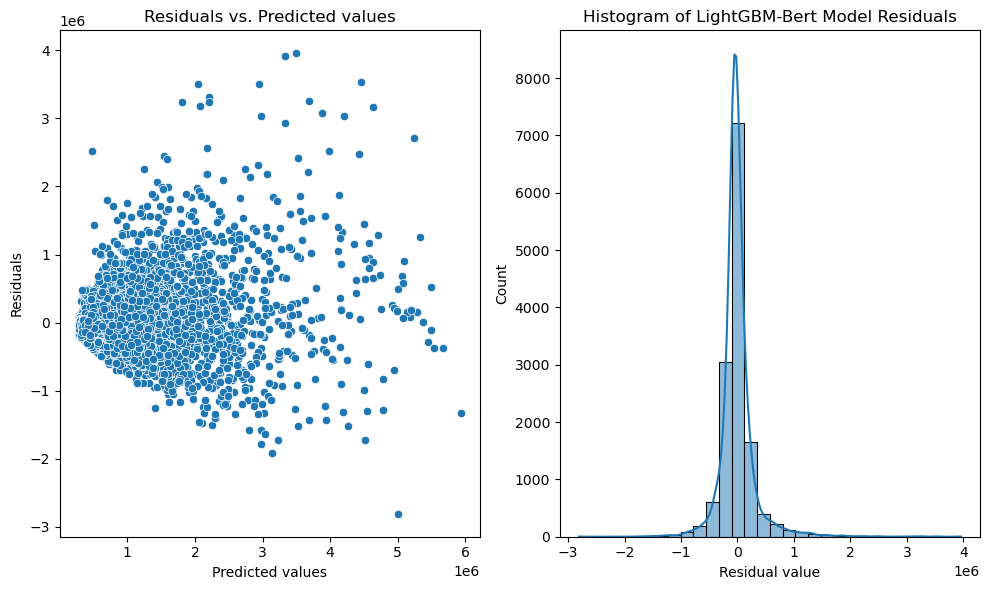

In [66]:
# splitting dependent variable and independent variables
X = bert_data.drop(columns=['price_target'])
y = bert_data['price_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define LightGBM regressor
model = lgb.LGBMRegressor()

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 60],
    'num_leaves': [15, 31, 63, 127],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'seed': [42]
}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, 
                                   scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1, cv=3, random_state=42)

random_search.fit(X_train, y_train)

# Check the best hyperparameters
print('Best Parameters:', random_search.best_params_)

best_rf = random_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Create an instance of MinMaxScaler
scaler_y = MinMaxScaler()

scaler_y.fit(df_original['price'].values.reshape(-1, 1))

# Inverse transform the predictions
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE: {mae}")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print('Mean Absolute Percentage Error:', mape)
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2: {r2}")

# Calculate residuals
residuals = y_test_original.ravel() - y_pred_original.ravel()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(y_pred_original.ravel(), residuals)
plt.title('Residuals vs. Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

# Plot histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of LightGBM-Bert Model Residuals')
plt.xlabel('Residual value')

plt.tight_layout()
plt.show()